In [2]:
# Imports & Set Path
import numpy as np
import pandas as pd
from pathlib import Path
import time, os

# Import data
IN_URL = "https://data.austintexas.gov/resource/wter-evkm.csv"
OUT_URL = "https://data.austintexas.gov/resource/9t4d-g238.csv"

raw_dir = Path("..") if (Path("..")/"raw_data").exists() else Path(".") / "raw_data"
raw_dir.mkdir(parents=True, exist_ok=True)

# Read in 1000 rows of the data to test the code first
#df_in = pd.read_csv(IN_URL, nrows=1000)
#df_out = pd.read_csv(OUT_URL, nrows=1000)

# Read in full data (large data with more than 10k rows)
# It doesn't work well with setting URL="...?$limit=...", so use fetch socrata instead.
def fetch_socrata_to_csv(base_url, out_csv, limit=50000, max_rows=None):
    """
    pagination from Socrata to out_csv
    - Resumable download: If out_csv already exists, resume writing from the current row count
    """
    start_offset = 0
    if Path(out_csv).exists():
        try:
            start_offset = max(sum(1 for _ in open(out_csv, "r", encoding="utf-8")) -1, 0)
            print(f"[Resume] Found existing {out_csv}, rows={start_offset}. Will continue from offset={start_offset}.")
        except Exception as e:
            print("Resume check failed:", e)
            start_offset = 0

    offset = start_offset
    total_written = start_offset
    t0 = time.time()
    header_written = Path(out_csv).exists() and start_offset > 0

    while True:
        url = f"{base_url}?$limit={limit}&$offset={offset}"
        try:
            chunk = pd.read_csv(url)
        except Exception as e:
            print(f"\nError fetching offset={offset}: {e}")
            print("Will retry in 5s ...")
            time.sleep(5)
            continue

        n = len(chunk)
        if n == 0:
            break

        chunk.to_csv(out_csv, mode="a" if header_written else "w", index=False, header=not header_written)
        header_written = True

        offset += n
        total_written += n

        dt = time.time() - t0
        speed = total_written / max(dt,1)
        print(f"\rFetched & saved: {total_written} rows (last chunk={n}, ~{speed:.1f} rows/s)", end="")

        if max_rows is not None and total_written >= max_rows:
            print("\nReached max_rows limit; stopping early.")
            break

        if n < limit:
            break

    print("\nDone ->", out_csv)
    return total_written

in_csv = raw_dir / "intakes.csv"
out_csv = raw_dir / "outcomes.csv"

rows_in = fetch_socrata_to_csv(IN_URL, in_csv, limit=50000)
rows_out = fetch_socrata_to_csv(OUT_URL, out_csv, limit=50000)
print("Rows (intakes):", rows_in)
print("Rows (outcomes):", rows_out)

df_in = pd.read_csv(in_csv)
df_out = pd.read_csv(out_csv)
print("Intakes shape: ", df_in.shape)
print("Outcomes shape: ", df_out.shape)

[Resume] Found existing ../intakes.csv, rows=173812. Will continue from offset=173812.

Done -> ../intakes.csv
[Resume] Found existing ../outcomes.csv, rows=173775. Will continue from offset=173775.

Done -> ../outcomes.csv
Rows (intakes): 173812
Rows (outcomes): 173775
Intakes shape:  (173812, 12)
Outcomes shape:  (173775, 12)


In [3]:
# Take a look at the data
display(df_in.head(3))
display(df_out.head(3))
print("Intakes columns: ", df_in.columns.tolist())
print("Outcomes columns: ", df_out.columns.tolist())

,animal_id,name,datetime,datetime2,found_location,intake_type,intake_condition,animal_type,sex_upon_intake,age_upon_intake,breed,color
0,A521520,Nina,2013-10-01T07:51:00.000,2013-10-01T07:51:00.000,Norht Ec in Austin (TX),Stray,Normal,Dog,Spayed Female,7 years,Border Terrier/Border Collie,White/Tan
1,A664235,NaN,2013-10-01T08:33:00.000,2013-10-01T08:33:00.000,Abia in Austin (TX),Stray,Normal,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White
2,A664236,NaN,2013-10-01T08:33:00.000,2013-10-01T08:33:00.000,Abia in Austin (TX),Stray,Normal,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White


,animal_id,date_of_birth,name,datetime,monthyear,outcome_type,outcome_subtype,animal_type,sex_upon_outcome,age_upon_outcome,breed,color
0,A668305,2012-12-01,NaN,2013-12-02T00:00:00-05:00,12-2013,Transfer,Partner,Other,Unknown,1 year,Turtle Mix,Brown/Yellow
1,A673335,2012-02-22,NaN,2014-02-22T00:00:00-05:00,02-2014,Euthanasia,Suffering,Other,Unknown,2 years,Raccoon,Black/Gray
2,A675999,2013-04-03,NaN,2014-04-07T00:00:00-05:00,04-2014,Transfer,Partner,Other,Unknown,1 year,Turtle Mix,Green


Intakes columns:  ['animal_id', 'name', 'datetime', 'datetime2', 'found_location', 'intake_type', 'intake_condition', 'animal_type', 'sex_upon_intake', 'age_upon_intake', 'breed', 'color']
Outcomes columns:  ['animal_id', 'date_of_birth', 'name', 'datetime', 'monthyear', 'outcome_type', 'outcome_subtype', 'animal_type', 'sex_upon_outcome', 'age_upon_outcome', 'breed', 'color']


In [5]:
# Data Cleaning
# 1) convert time to UTC - then naive
def to_utc_naive(series):
    ts = pd.to_datetime(series, errors='coerce', utc=True)
    return ts.dt.tz_convert('UTC').dt.tz_localize(None)

df_in["intake_ts"] = to_utc_naive(df_in["datetime"])
df_out["outcome_ts"] = to_utc_naive(df_out["datetime"])

# 2) convert age to days
def age_to_days(s):
    if pd.isna(s):
        return np.nan
    s = str(s).strip().lower()
    parts = s.split()
    if len(parts) < 2:
        return np.nan

    try:
        n = float(parts[0])
    except:
        return np.nan
    unit = parts[1]
    if "day" in unit: return n
    if "week" in unit: return n * 7
    if "month" in unit: return n * 30
    if "year" in unit: return n * 365
    return np.nan

df_in["age_upon_intake_days"] = df_in["age_upon_intake"].map(age_to_days)
df_out["age_upon_outcome_days"] = df_out["age_upon_outcome"].map(age_to_days)

# 3) For MonthYear, simply use the first day of each month   
missing_out = df_out["outcome_ts"].isna() & df_out["monthyear"].notna()
if missing_out.any():
    m = pd.to_datetime(df_out.loc[missing_out, "monthyear"], format='%m-%Y', errors='coerce', utc=True)
    df_out.loc[missing_out, "outcome_ts"] = m.dt.tz_convert("UTC").dt.tz_localize(None)

print("Intakes time ok:", df_in["intake_ts"].notna().mean())
print("Outcomes time ok:", df_out["outcome_ts"].notna().mean())

Intakes time ok: 1.0
Outcomes time ok: 1.0


In [6]:
# Combine timeline & Ingroup bfill
aid      = "animal_id"
time_in  = "intake_ts" 
time_out = "outcome_ts"

# 1) Keep only the necessary columns to reduce memory
in_keep = [c for c in [
    aid, time_in,
    "name","found_location","intake_type","intake_condition","animal_type",
    "sex_upon_intake","age_upon_intake","age_upon_intake_days","breed","color"
] if c in df_in.columns]

out_keep = [c for c in [
    aid, time_out,
    "outcome_type","outcome_subtype","animal_type","sex_upon_outcome",
    "age_upon_outcome","age_upon_outcome_days","breed","color"
] if c in df_out.columns]

df_in_  = df_in[in_keep].copy()
df_out_ = df_out[out_keep].copy()

# 2) Unify dtype
df_in_[aid]   = df_in_[aid].astype(str)
df_out_[aid]  = df_out_[aid].astype(str)
df_in_[time_in]   = pd.to_datetime(df_in_[time_in],  errors="coerce", utc=True).dt.tz_convert("UTC").dt.tz_localize(None)
df_out_[time_out] = pd.to_datetime(df_out_[time_out], errors="coerce", utc=True).dt.tz_convert("UTC").dt.tz_localize(None)

df_in_  = df_in_.dropna(subset=[aid, time_in]).copy()
df_out_ = df_out_.dropna(subset=[aid, time_out]).copy()

# 3) Add prefix out_ for outcomes & Rename time column to event_ts
df_in_  = df_in_.rename(columns={time_in: "event_ts"})
df_out_ = df_out_.rename(columns={time_out: "event_ts"})
df_out_ = df_out_.rename(columns={c: f"out_{c}" for c in df_out_.columns if c not in [aid, "event_ts"]})

for c in [c for c in df_out_.columns if c.startswith("out_")]:
    if c not in df_in_.columns:
        df_in_[c] = np.nan

# 4) Combine timeline
df_in_["__kind__"]  = "intake"
df_out_["__kind__"] = "outcome"
common_cols = sorted(set(df_in_.columns) | set(df_out_.columns))
union_cols = [aid, "event_ts", "__kind__"] + [c for c in common_cols if c not in [aid, "event_ts", "__kind__"]]

df_in_aligned  = df_in_.reindex(columns=union_cols)
df_out_aligned = df_out_.reindex(columns=union_cols)
timeline = pd.concat([df_in_aligned, df_out_aligned], ignore_index=True)
timeline.sort_values([aid, "event_ts"], inplace=True, kind="mergesort")
timeline.reset_index(drop=True, inplace=True)

# 5) Ingroup bfill
timeline["outcome_ts_tmp"] = np.where(timeline["__kind__"]=="outcome", timeline["event_ts"], pd.NaT)
out_cols = [c for c in timeline.columns if c.startswith("out_")] + ["outcome_ts_tmp"]

for c in out_cols:
    timeline[c] = timeline.groupby(aid, group_keys=False)[c].bfill()

# 6) Retrieve intake column
df_pair = timeline[timeline["__kind__"]=="intake"].copy()
df_pair.rename(columns={"event_ts":"intake_ts", "outcome_ts_tmp":"out_outcome_ts"}, inplace=True)


# 7) Calculate in-shelter time & Remove negatives
df_pair["intake_ts"] = pd.to_datetime(df_pair["intake_ts"], errors="coerce")
df_pair["out_outcome_ts"] = pd.to_datetime(df_pair["out_outcome_ts"], errors="coerce")

mask = df_pair["intake_ts"].notna() & df_pair["out_outcome_ts"].notna()
df_pair.loc[mask, "shelter_days"] = (
    (df_pair.loc[mask, "out_outcome_ts"].values - df_pair.loc[mask, "intake_ts"].values)/ np.timedelta64(1, "D")
)
df_pair.loc[~mask, "shelter_days"] = np.nan

neg = (df_pair["shelter_days"] < 0).sum(skipna=True)
if neg:
    print(f"Found {neg} rows with shelter_days < 0; excluded.")
    df_pair = df_pair[(df_pair["shelter_days"].isna()) | (df_pair["shelter_days"] >= 0)].copy()

# 9) Unmatched masks & Modeling sets
unmatched_mask = df_pair["out_outcome_ts"].isna()
df_pair_model = df_pair[~unmatched_mask].copy()
unmatched_ratio = unmatched_mask.mean()
matched_ratio = 1 - unmatched_ratio
print("df_pair shape:", df_pair.shape, "| df_pair_model shape:", df_pair_model.shape)
print(f"Matched ratio: {matched_ratio:.2%} | Unmatched ratio: {unmatched_ratio:.2%}")

# 10) Take a look at df_pair and df_pair_model
print("\nPreview df_pair:")
display(df_pair.head(3))

print("\nPreview df_pair_model for ML:")
display(df_pair_model.head(3))

df_pair shape: (173812, 23) | df_pair_model shape: (73557, 23)
Matched ratio: 42.32% | Unmatched ratio: 57.68%

Preview df_pair:


,animal_id,intake_ts,__kind__,age_upon_intake,age_upon_intake_days,animal_type,breed,color,found_location,intake_condition,...,out_age_upon_outcome_days,out_animal_type,out_breed,out_color,out_outcome_subtype,out_outcome_type,out_sex_upon_outcome,sex_upon_intake,out_outcome_ts,shelter_days
1,A006100,2014-03-07 14:26:00,intake,6 years,2190.0,Dog,Spinone Italiano Mix,Yellow/White,8700 Research in Austin (TX),Normal,...,2555.0,Dog,Spinone Italiano Mix,Yellow/White,NaN,Return to Owner,Neutered Male,Neutered Male,2014-12-01 00:00:00,268.398611
3,A006100,2014-12-19 10:21:00,intake,7 years,2555.0,Dog,Spinone Italiano Mix,Yellow/White,8700 Research Blvd in Austin (TX),Normal,...,3650.0,Dog,Spinone Italiano Mix,Yellow/White,NaN,Return to Owner,Neutered Male,Neutered Male,2017-12-07 05:00:00,1083.777083
5,A006100,2017-12-07 14:07:00,intake,10 years,3650.0,Dog,Spinone Italiano Mix,Yellow/White,Colony Creek And Hunters Trace in Austin (TX),Normal,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Neutered Male,NaT,NaN



Preview df_pair_model for ML:


,animal_id,intake_ts,__kind__,age_upon_intake,age_upon_intake_days,animal_type,breed,color,found_location,intake_condition,...,out_age_upon_outcome_days,out_animal_type,out_breed,out_color,out_outcome_subtype,out_outcome_type,out_sex_upon_outcome,sex_upon_intake,out_outcome_ts,shelter_days
1,A006100,2014-03-07 14:26:00,intake,6 years,2190.0,Dog,Spinone Italiano Mix,Yellow/White,8700 Research in Austin (TX),Normal,...,2555.0,Dog,Spinone Italiano Mix,Yellow/White,NaN,Return to Owner,Neutered Male,Neutered Male,2014-12-01 00:00:00,268.398611
3,A006100,2014-12-19 10:21:00,intake,7 years,2555.0,Dog,Spinone Italiano Mix,Yellow/White,8700 Research Blvd in Austin (TX),Normal,...,3650.0,Dog,Spinone Italiano Mix,Yellow/White,NaN,Return to Owner,Neutered Male,Neutered Male,2017-12-07 05:00:00,1083.777083
26,A200922,2013-10-03 15:47:00,intake,16 years,5840.0,Dog,Dachshund Mix,Black/Tan,Austin (TX),Normal,...,5840.0,Dog,Dachshund Mix,Black/Tan,Foster,Adoption,Neutered Male,Neutered Male,2013-11-01 00:00:00,28.342361


In [9]:
# Labeling
# Binary classification (Live vs Nonlive) (Did in another notebook)
LIVE_TYPES = {"Adoption", "Return to Owner", "Transfer", "Relocate"}
NON_LIVE_TYPES = {"Euthanasia", "Died", "Disposal", "Missing", "Rto-Euthanasia"}

def map_live(x):
    if pd.isna(x):
        return np.nan
    x = str(x).strip()
    if x in LIVE_TYPES:
        return 1
    if x in NON_LIVE_TYPES:
        return 0
    return np.nan

out_type_col = "out_outcome_type" if "out_outcome_type" in df_pair_model.columns else \
                next((c for c in df_pair.columns if c.endswith("outcome_type")), None)
assert out_type_col is not None, "Can't find the outcome_type column in df_pair."

df_pair_model["live_outcome"] = df_pair_model[out_type_col].map(map_live)

In [10]:
# Multi-class classification
# merge rare categories into "Other" to avoid extreme imbalance
min_count = 100
vc = df_pair_model[out_type_col].value_counts()
major_classes = set(vc[vc >= min_count].index)
def map_multi(x):
    if pd.isna(x): return np.nan
    x = str(x).strip()
    return x if x in major_classes else "Other"

df_pair_model["outcome_multi"] = df_pair_model[out_type_col].map(map_multi)
df_pair_model = df_pair_model.dropna(subset=["outcome_multi"]).copy()

print("Multiclass classes:", sorted(df_pair_model["outcome_multi"].unique()))

Multiclass classes: ['Adoption', 'Died', 'Disposal', 'Euthanasia', 'Other', 'Return to Owner', 'Rto-Adopt', 'Transfer']


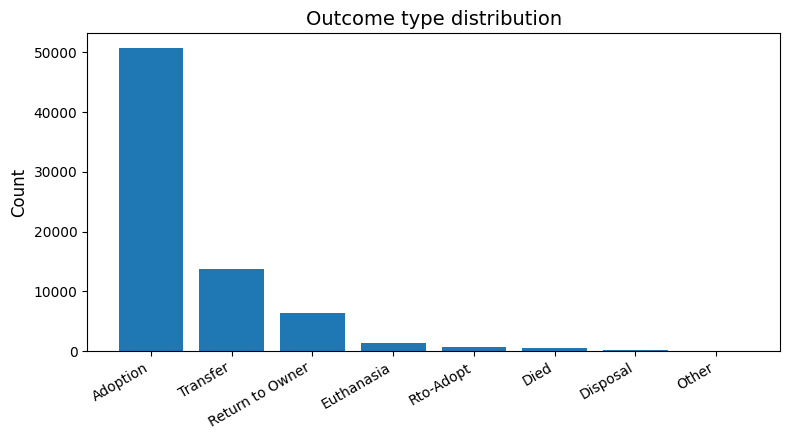

Saved: ../figures/bar_outcome_multi_distribution.png


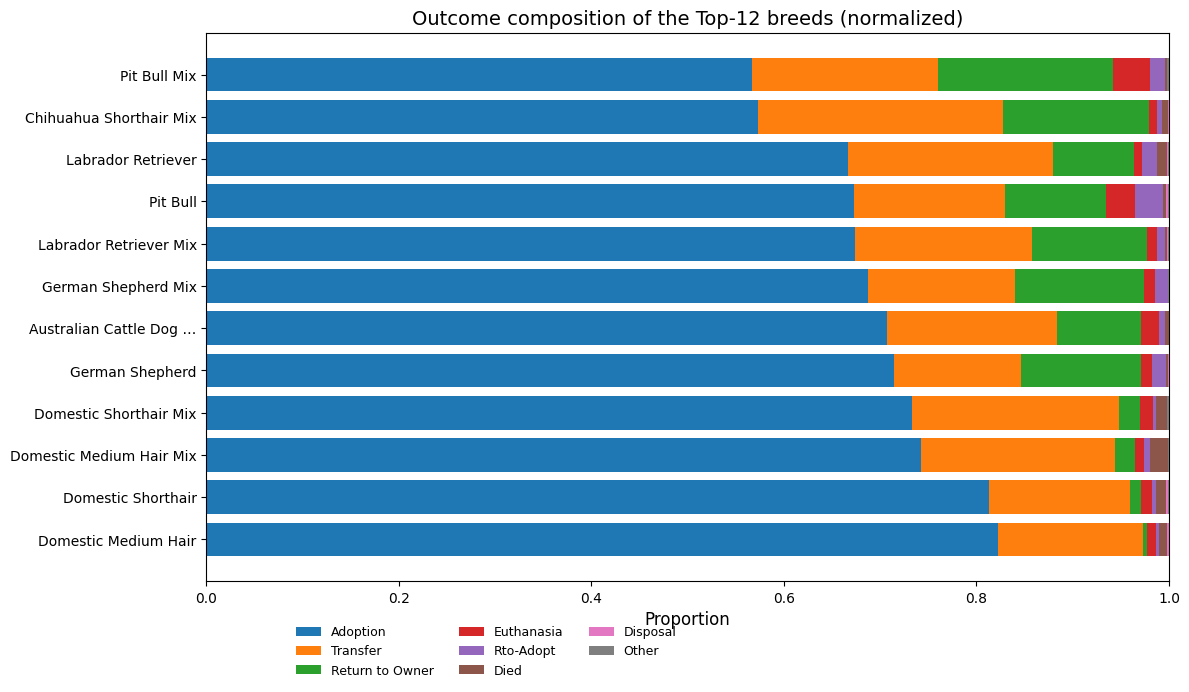

Saved: ../figures/stacked_breed_outcomes_normalized.png


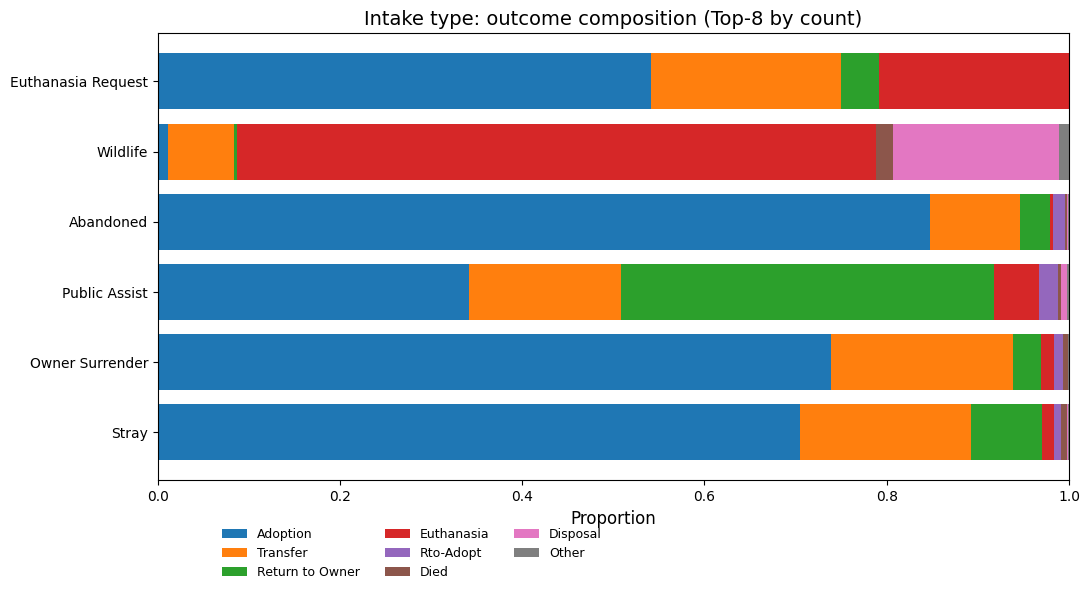

Saved: ../figures/stacked_intake_type_outcomes_normalized.png


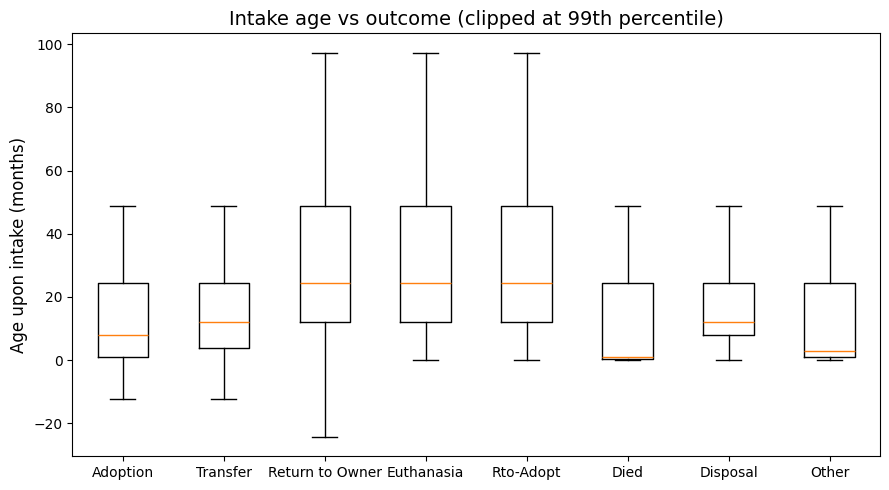

Saved: ../figures/box_intake_age_by_outcome.png


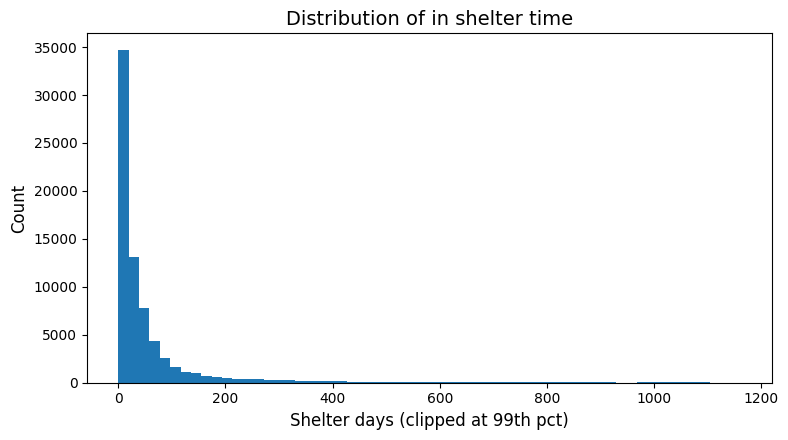

Saved: ../figures/hist_shelter_days_clipped.png


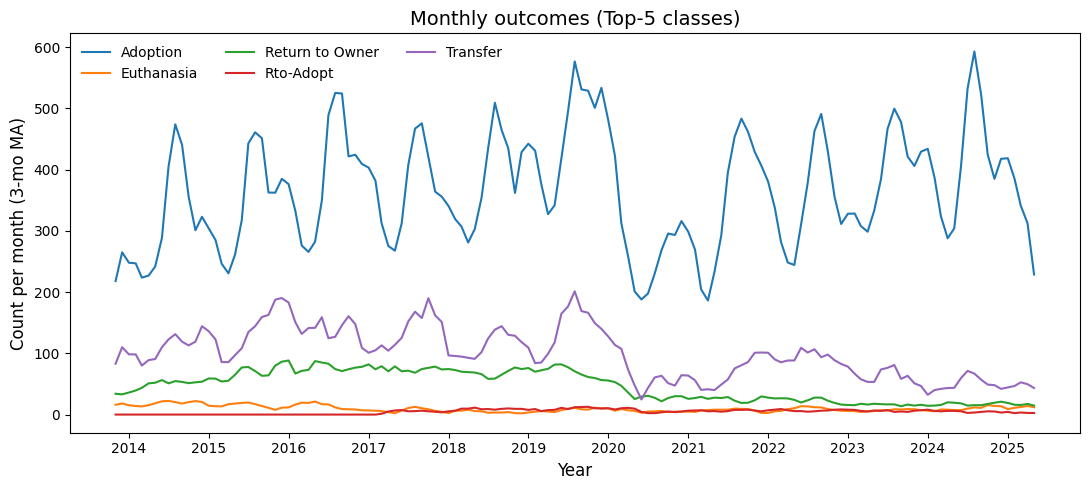

Saved: ../figures/line_monthly_outcomes_top5.png


In [28]:
# EDA Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

eda = df_pair_model.dropna(subset=["outcome_multi"]).copy()
eda["outcome_multi"] = eda["outcome_multi"].astype(str)

fig_dir = (Path("..") if (Path("..")/"raw_data").exists() else Path(".")) / "figures"
fig_dir.mkdir(parents=True, exist_ok=True)

plt.rcParams.update({
    "figure.figsize": (8,4.5),
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
})

def save_show_plt(figpath):
    plt.tight_layout()
    plt.savefig(figpath, dpi=200)
    plt.show()
    print("Saved:", figpath)

def norm_crosstab(df, row, col, topk=None):
    """
    return crosstab plot normalized by row；
    Select the top k classes from the row
    """
    
    if topk:
        top_vals = df[row].value_counts().head(topk).index
        df = df[df[row].isin(top_vals)]
    ct = pd.crosstab(df[row], df[col])
    ct = ct.div(ct.sum(axis=1), axis=0)
    return ct

# 1) Multi-Class Label Distribution (Bar Plot)
cls_counts = eda["outcome_multi"].value_counts().sort_values(ascending=False)
plt.figure()
x = np.arange(len(cls_counts))
plt.bar(x, cls_counts.values)
plt.xticks(x, cls_counts.index, rotation=30, ha="right")
plt.ylabel("Count")
plt.title("Outcome type distribution")
save_show_plt(fig_dir / "bar_outcome_multi_distribution.png")

# 2) Multi-class composition of the top-12 breeds (Stacked Bar Plot) (normalized)
ct_breed = norm_crosstab(eda.dropna(subset=["breed"]), "breed", "outcome_multi", topk=12)
cls_order = eda["outcome_multi"].value_counts().index.tolist()
ct_breed = ct_breed.reindex(columns=[c for c in cls_order if c in ct_breed.columns])

sort_key = "Adoption" if "Adoption" in ct_breed.columns else None
if sort_key:
    ct_breed = ct_breed.sort_values(by=sort_key, ascending=False)
else:
    ct_breed = ct_breed.sort_values(by=list(ct_breed.columns), ascending=False)

labels = [s if len(s) <= 24 else s[:22] + "…" for s in ct_breed.index]
ypos = np.arange(len(ct_breed))

plt.figure(figsize=(12, 7))
bottom = np.zeros(len(ct_breed))
for c in ct_breed.columns:
    plt.barh(ypos, ct_breed[c].values, left=bottom, label=c)
    bottom += ct_breed[c].values
    
plt.yticks(ypos, labels)
plt.xlim(0,1)
plt.xlabel("Proportion")
plt.title("Outcome composition of the Top-12 breeds (normalized)")
plt.legend(ncol=3, fontsize=9, frameon=False, loc="best", bbox_to_anchor=(0.5, -0.06))
plt.tight_layout(rect=[0, 0.06, 1, 1])
save_show_plt(fig_dir / "stacked_breed_outcomes_normalized.png")

# 3) Multi-class composition for different intake_type (Stacked Bar Plot) (normalized)
ct_intake = norm_crosstab(eda.dropna(subset=["intake_type"]), "intake_type", "outcome_multi", topk=8)
cls_order = eda["outcome_multi"].value_counts().index.tolist()
ct_intake = ct_intake.reindex(columns=[c for c in cls_order if c in ct_intake.columns])

row_counts = eda["intake_type"].value_counts()
order = [r for r in row_counts.index if r in ct_intake.index][:8]
ct_intake = ct_intake.loc[order]

labels = [s if len(s) <= 20 else s[:18] + "…" for s in ct_intake.index]
ypos = np.arange(len(ct_intake))

plt.figure(figsize=(11, 6))
bottom = np.zeros(len(ct_intake))
for c in ct_intake.columns:
    plt.barh(ypos, ct_intake[c].values, left=bottom, label=c)
    bottom += ct_intake[c].values

plt.yticks(ypos, labels)
plt.xlim(0, 1)
plt.xlabel("Proportion")
plt.title("Intake type: outcome composition (Top-8 by count)")
plt.legend(ncol=3, fontsize=9, frameon=False, loc="best", bbox_to_anchor=(0.5, -0.08))
plt.tight_layout(rect=[0, 0.08, 1, 1])
save_show_plt(fig_dir / "stacked_intake_type_outcomes_normalized.png")

# 4) Intake age VS Outcomes (Box Plot) (clipped at 99th percentile)
# change days into months to avoid long-tail compression
eda["age_months"] = eda["age_upon_intake_days"] / 30.0
hi = np.nanpercentile(eda["age_months"], 99)
sub = eda[eda["age_months"] <= hi].dropna(subset=["age_months"])
# order outcome by frequency
order = sub["outcome_multi"].value_counts().index.tolist()
data = [sub.loc[sub["outcome_multi"]==c, "age_months"].values for c in order if len(sub.loc[sub["outcome_multi"]==c])>=20]
labels = [c for c in order if len(sub.loc[sub["outcome_multi"]==c])>=20]
if len(labels) >= 2:
    plt.figure(figsize=(9,5))
    plt.boxplot(data, tick_labels=labels, showfliers=False)
    plt.ylabel("Age upon intake (months)")
    plt.title("Intake age vs outcome (clipped at 99th percentile)")
    save_show_plt(fig_dir / "box_intake_age_by_outcome.png")
else:
    print("Skip age boxplot: no enough categories with data.")

# 5) In shelter time distribution (Histogram) (clipped at 99th percentile)
sd = eda["shelter_days"].dropna().values
hi = np.nanpercentile(sd, 99)
plt.figure()
plt.hist(sd[sd <= hi], bins=60)
plt.xlabel("Shelter days (clipped at 99th pct)")
plt.ylabel("Count")
plt.title("Distribution of in shelter time")
save_show_plt(fig_dir / "hist_shelter_days_clipped.png")

# 6) Outcome VS Month (Top-5 count classes)
monthly = eda.dropna(subset=["out_outcome_ts"]).copy()
monthly["ym"] = pd.to_datetime(monthly["out_outcome_ts"]).dt.to_period("M").dt.to_timestamp()
top5 = eda["outcome_multi"].value_counts().head(5).index.tolist()
pivot = (monthly[monthly["outcome_multi"].isin(top5)]
    .pivot_table(index="ym", columns="outcome_multi", values="animal_id", aggfunc="count", fill_value=0)
    .sort_index())
if len(pivot) > 0:
    pivot_ma = pivot.rolling(window=3, min_periods=1).mean()
    fig, ax = plt.subplots(figsize=(11,5))
    for c in pivot_ma.columns:
        ax.plot(pivot_ma.index, pivot_ma[c].values, label=c)

    months = len(pivot_ma)
    span_years = (pivot_ma.index.max() - pivot_ma.index.min()).days / 365

    if span_years >= 3:
        ax.xaxis.set_major_locator(mdates.YearLocator())          # Every year
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    else:
        ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, interval=6))  # Every six months
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
        
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center")
    ax.set_xlabel("Year")
    ax.set_ylabel("Count per month (3-mo MA)")
    ax.set_title("Monthly outcomes (Top-5 classes)")
    ax.legend(ncol=3, frameon=False, loc="upper left")

    plt.tight_layout()
    save_show_plt(fig_dir / "line_monthly_outcomes_top5.png")

In [13]:
# Feature pruning (to avoid leakage)
def coalesce(a, b):
    if b is None: return a
    return a.where(a.notna() & (a.astype(str).str.strip()!=""), b)

feat_cols = {
    "animal_type": ("animal_type", "out_animal_type"),
    "breed": ("breed", "out_breed"),
    "color": ("color", "out_color"),
    "intake_type": ("intake_type", None),
    "intake_condition": ("intake_condition", None),
    "sex_upon_intake": ("sex_upon_intake", "out_sex_upon_outcome"),
    "age_upon_intake_days": ("age_upon_intake_days", None)
}
use_df = pd.DataFrame(index=df_pair_model.index)
for k,(a,b) in feat_cols.items():
    if a in df_pair_model.columns:
        series_a = df_pair_model[a]
        series_b = (df_pair_model[b] if (b and (b in df_pair_model.columns)) else None)
        use_df[k] = coalesce(series_a, series_b)
use_df["animal_id"] = df_pair_model["animal_id"]

y_multi = df_pair_model["outcome_multi"]
print("X:", use_df.shape, "| y_multi:", y_multi.shape)

X: (73542, 8) | y_multi: (73542,)


In [14]:
# Splitting & Preprocessing
from sklearn.model_selection import GroupShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

# Feature selection
cat_cols = ["animal_type", "breed", "color", "intake_type", "intake_condition", "sex_upon_intake"]
num_cols = ["age_upon_intake_days"]
group_col = "animal_id"

X = use_df[cat_cols + num_cols]
y = y_multi
groups = use_df[group_col]

print("X shape: ", X.shape)
print("y shape: ", y.shape)

X shape:  (73542, 7)
y shape:  (73542,)


In [15]:
# Group-based split: train/val/test = 70/15/15
gss1 = GroupShuffleSplit(n_splits=1, train_size=0.85, random_state=42)
trainval_idx, test_idx = next(gss1.split(X, y, groups=groups))
X_trainval, X_test = X.iloc[trainval_idx], X.iloc[test_idx]
y_trainval, y_test = y.iloc[trainval_idx], y.iloc[test_idx]
groups_trainval = groups.iloc[trainval_idx]

gss2 = GroupShuffleSplit(n_splits=1, train_size=0.8235, random_state=42)
train_idx, val_idx = next(gss2.split(X_trainval, y_trainval, groups=groups_trainval))
X_train, X_val = X_trainval.iloc[train_idx], X_trainval.iloc[val_idx]
y_train, y_val = y_trainval.iloc[train_idx], y_trainval.iloc[val_idx]

print("n_train:", len(X_train), "n_val:", len(X_val), "n_test:", len(X_test))

n_train: 51451 n_val: 11035 n_test: 11056


In [20]:
# Preprocessing & Logistic Regression
preprocessor = ColumnTransformer([
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
    ("num", Pipeline([("imp", SimpleImputer(strategy="median")), ("scale", StandardScaler())]), num_cols)
])

clf_multi = Pipeline(steps = [
    ("prep", preprocessor),
    ("logreg", LogisticRegression(penalty="l2", C=1.0, solver="lbfgs", max_iter=1000, class_weight="balanced", random_state=0))
])

# only fit on train set
clf_multi.fit(X_train, y_train)

# validation and test
val_pred = clf_multi.predict(X_val)
test_pred = clf_multi.predict(X_test)

val_score = accuracy_score(y_val, val_pred)
test_score = accuracy_score(y_test, test_pred)

print("Validation accuracy:", val_score)
print("Test accuracy:", test_score)

print("\nValidation classification report:")
print(classification_report(y_val, val_pred))
print("\nTest classification report:")
print(classification_report(y_test, test_pred))

Validation accuracy: 0.2393294064340734
Test accuracy: 0.24176917510853835

Validation classification report:
                 precision    recall  f1-score   support

       Adoption       0.79      0.23      0.36      7562
           Died       0.01      0.34      0.03        68
       Disposal       0.05      0.68      0.09        19
     Euthanasia       0.08      0.25      0.11       212
          Other       0.00      0.13      0.00        15
Return to Owner       0.30      0.51      0.38       952
      Rto-Adopt       0.02      0.24      0.03        92
       Transfer       0.25      0.13      0.17      2115

       accuracy                           0.24     11035
      macro avg       0.19      0.31      0.15     11035
   weighted avg       0.61      0.24      0.31     11035


Test classification report:
                 precision    recall  f1-score   support

       Adoption       0.80      0.24      0.37      7590
           Died       0.01      0.24      0.02        80
  

In [21]:
# Confusion Matrix
print("\nTest confusion matrix:")
print(confusion_matrix(y_test, test_pred, labels=sorted(y.unique())))


Test confusion matrix:
[[1807 1234  157  391 1581  722  994  704]
 [  15   19    5    7   17    1    9    7]
 [   1    1   15    3    3    0    1    0]
 [  12   27   25   34   20   33   19   11]
 [   3    3    1    2    3    1    0    3]
 [  80   37   16   78   82  514  121   69]
 [  16    9    5   19    6   18   33    6]
 [ 332  382   75  145  343  255  276  248]]


In [23]:
# 多数类基线
major = y_train.value_counts().idxmax()
maj_acc = (y_test == major).mean()
print("Majority-class baseline accuracy:", maj_acc)

Majority-class baseline accuracy: 0.6865050651230101
